RoBERTa (A Robustly Optimized BERT Pretraining Approach) BERT(Bidirectional Encoder Representations from Transformers) RoBERTa iterates on BERT's pretraining procedure, including training the model longer, with bigger batches over more data; removing the next sentence prediction objective; training on longer sequences; and dynamically changing the masking pattern applied to the training data.

BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling

In [1]:
pip install transformers


     |████████████████████████████████| 491kB 2.8MB/s 
     |████████████████████████████████| 870kB 13.7MB/s 
     |████████████████████████████████| 1.0MB 12.9MB/s 
     |████████████████████████████████| 3.8MB 21.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=472038fa689c967d1f75e5b2210547b6b74613e0c6f20c1ab0b5bdb67ac95e6b
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [2]:
pip install fastai

In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [4]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [5]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
2.1.0


In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
!pip install chart_studio

In [8]:
pip install scikit-plot

In [0]:
from fastai.text import *
from fastai.metrics import *
from transformers import RobertaTokenizer

In [0]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2019,
    roberta_model_name='roberta-base', # can also be exchnaged with roberta-base 
    max_lr=1e-5,
    epochs=4,
    use_fp16=False,
    bs=16, 
    max_seq_len=256, 
    num_labels = 2,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)

In [0]:
import pandas as pd
import io
import os

In [47]:
## Mount Drive into Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Roberta_models/Binary/12&45")
os.listdir()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['models',
 'actual_test_data.csv',
 'trial.csv',
 'mymodel.path1',
 'binary.png',
 '12&45.ipynb',
 'actual_test_data (1).csv',
 'trial (1).csv']

In [49]:
from google.colab import files
uploaded = files.upload()

Saving actual_test_data.csv to actual_test_data (1).csv
Saving trial.csv to trial (1).csv


In [50]:
df = pd.read_csv(io.StringIO(uploaded['trial.csv'].decode('utf-8')))
df.head(3)

,Unnamed: 0,asin,overall,reviewText,summary,summary_length,review_length
0,416916,B00JMEMQ5W,1,This is NOT what you get. This case has a stic...,I will not be purchasing a case like this or f...,68,212
1,358398,B00HPC170I,1,Headline says 30000 mah\nDiscription reads 800...,wow what junk,13,96
2,470011,B00LFDHZDG,1,"Fit the phone nicely, but the first time I dro...",One Star,8,74


In [51]:
test_df = pd.read_csv(io.StringIO(uploaded['actual_test_data.csv'].decode('utf-8')))
test_df.head(3)

,Unnamed: 0,reviews,label
0,1155,broke almost fit phone well minute bolster got...,1
1,12058,exactly needed shorter cable standard size com...,5
2,7592,best screen protector use nothing else,5


In [0]:
df = df[["reviewText","overall"]]

In [0]:
test_df = test_df[["reviews","label"]]

In [54]:
df.head(2)

,reviewText,overall
0,This is NOT what you get. This case has a stic...,1
1,Headline says 30000 mah\nDiscription reads 800...,1


In [55]:
df.isna().sum()

reviewText    0
overall       0
dtype: int64

In [56]:
test_df.isna().sum()

reviews    3
label      0
dtype: int64

In [0]:
df = df.dropna(axis=0, how ='any')

In [0]:
test_df = test_df.dropna(axis=0, how ='any')

In [59]:
df.shape

(13190, 2)

In [60]:
test_df.shape

(2286, 2)

In [61]:
if config.testing: df = df[:5000]
print(df.shape)

(13190, 2)


In [0]:
df = df.rename(columns={"reviewText": "review", "overall": "sentiment"})

In [0]:
df = df[df.sentiment != 3]

In [0]:
test_df = test_df[test_df.label != 3]

In [0]:
df = df.replace({'sentiment': {1: 'Neg', 2: 'Neg', 4: 'Pos', 5: 'Pos'}})

In [0]:
test_df = test_df.replace({'label': {1: 'Neg', 2: 'Neg', 4: 'Pos', 5: 'Pos'}})

In [67]:
df.head(5)

,review,sentiment
0,This is NOT what you get. This case has a stic...,Neg
1,Headline says 30000 mah\nDiscription reads 800...,Neg
2,"Fit the phone nicely, but the first time I dro...",Neg
3,I ordered 2 of these. I bent the clip on mine...,Neg
4,Cheap material,Neg


In [68]:
df.head(5)

,review,sentiment
0,This is NOT what you get. This case has a stic...,Neg
1,Headline says 30000 mah\nDiscription reads 800...,Neg
2,"Fit the phone nicely, but the first time I dro...",Neg
3,I ordered 2 of these. I bent the clip on mine...,Neg
4,Cheap material,Neg


In [0]:
feat_cols = "review"
label_cols = "sentiment"

In [0]:
feat_cols1 = "reviews"

In [0]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

In [0]:
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

In [73]:
roberta_tok

In [0]:
import json

In [75]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
path = F"/content/gdrive/My Drive/Roberta_models/Binary/12&45" 

In [77]:
roberta_tok.save_vocabulary(path)

('/content/gdrive/My Drive/Roberta_models/Binary/12&45/vocab.json',
 '/content/gdrive/My Drive/Roberta_models/Binary/12&45/merges.txt')

In [78]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Roberta_models/Binary/12&45")
os.listdir()

Mounted at /content/drive


['actual_test_data.csv',
 'trial.csv',
 '12&45.ipynb',
 'actual_test_data (1).csv',
 'trial (1).csv',
 'vocab.json',
 'merges.txt']

In [0]:
# create fastai vocabulary for roberta

with open('vocab.json', 'r', encoding='utf-8') as f:
    roberta_vocab_dict = json.load(f)

In [0]:
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))


In [0]:
# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

In [0]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [0]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [0]:
import concurrent.futures

# loading the tokenizer and vocab processors
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

In [85]:
processor

In [86]:
# creating our databunch 
data = RobertaTextList.from_df(df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=config.seed) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .add_test(RobertaTextList.from_df(test_df, ".", cols=feat_cols1, processor=processor)) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)

In [87]:
data

RobertaDataBunch;

Train: LabelList (9247 items)
x: RobertaTextList
<s> This Ġis ĠNOT Ġwhat Ġyou Ġget . ĠThis Ġcase Ġhas Ġa Ġsticker Ġwith Ġfaded Ġcoloring Ġon Ġthe Ġback Ġor Ġa Ġcheap Ġplastic Ġcover . ĠThis Ġwas Ġnot Ġeven Ġworth Ġreturning . ĠI Ġwill Ġnot Ġbe Ġpurchasing Ġa Ġcase Ġlike Ġthis Ġor Ġfrom Ġthis Ġcompany Ġagain . </s>,<s> Head line Ġsays Ġ3 0000 Ġmah Ċ Disc ription Ġreads Ġ8000 Ġmah Ċ Features Ġreads Ġ6000 Ġmah Ċ M akes Ġyou Ġwonder Ġl ma o </s>,<s> I Ġordered Ġ2 Ġof Ġthese . Ġ ĠI Ġbent Ġthe Ġclip Ġon Ġmine Ġthe Ġ2 nd Ġday ĠI Ġowned Ġit , Ġand ĠI Ġuse Ġit Ġon Ġa Ġbelt . Ġ ĠMy Ġwife Ġuses Ġhers Ġto Ġclip Ġon Ġthe Ġedge Ġof Ġher Ġpocket Ġand Ġthe Ġclip Ġwasn 't Ġstrong Ġenough Ġto Ġhold . Ġ ĠNeither Ġcase Ġwould Ġhold Ġa ĠSamsung ĠS 3 Ġwith Ġa Ġcover Ġon Ġit , Ġand ĠI 'm Ġtalking Ġonly Ġa ĠMy Bat Ġcover , Ġnot Ġone Ġof Ġthe Ġbullet proof ĠMil - Spec Ġones . Ġ ĠIf Ġyou 're Ġusing Ġa Ġsmaller Ġsmartphone , Ġor Ġdon 't Ġmind Ġremoving Ġthe Ġprotective Ġcover , Ġit Ġwould Ġbe 

In [0]:
# Building the Model

In [0]:
import torch.nn as nn
from transformers import RobertaModel

# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=2):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits

In [90]:
roberta_model = CustomRobertaModel(num_labels=config.num_labels)

learn = Learner(data, roberta_model, metrics=[accuracy])

In [91]:
learn.model.roberta.train() # setting roberta to train as it is in eval mode by default
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.199924,0.150240,0.945911,01:32
1,0.161664,0.153636,0.942016,01:46
2,0.095003,0.131488,0.950671,01:52
3,0.067495,0.140577,0.950671,01:39


In [92]:
learn.model.roberta.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [93]:
learn.show_results()

text,target,prediction
"<s> < div Ġid ="" video - block - R 3 E Q 7 CL II J LC IR "" Ġclass ="" a - section Ġa - sp acing - small Ġa - sp acing - top - mini Ġvideo - block ""></ div >< input Ġtype ="" hidden "" Ġname ="""" Ġvalue ="" https :// images - na . ssl - images - amazon . com / images /",Pos,Pos
"<s> The Ġphone Ġworks Ġgreat Ġand Ġit Ġcame Ġwith Ġdouble Ġminutes Ġfor Ġlife - Ġeven Ġthough ĠI Ġbought Ġthe Ġsame Ġthing Ġseparately Ġwithout Ġknowing . Ġ ĠIt ĠNEED S Ġa Ġcover , Ġbut Ġyou Ġcan Ġread Ġmy Ġreview Ġon Ġthe Ġreally ĠCH E AP ĠB ODY ĠGL O VE Ġcover Ġthat Ġis Ġmade Ġfor Ġthe ĠLG ĠAcc ol ade Ġbut Ġfits Ġthis Ġphone Ġperfectly Ġwith Ġonly Ġslight Ġmodifications Ġ( elong",Pos,Pos
<s> This Ġis Ġa Ġgreat Ġcase !! Ġ ĠIt Ġis Ġaffordable Ġand Ġit Ġperforms Ġlike Ġa Ġcase Ġthat Ġcost Ġ$ 50 Ġor Ġmore !! Ġ ĠI Ġpurchased Ġthis Ġcase Ġfor Ġmy Ġtwo Ġkid 's ĠZ TE ĠN 800 Ġphones Ġon ĠVirgin ĠMobile Ġand Ġit Ġis Ġperforming Ġvery Ġwell Ġon Ġboth Ġof Ġthem . Ġ ĠThe Ġstyl us Ġthat Ġis Ġsupplied Ġis Ġa ĠPOS Ġbut Ġno Ġone Ġuses Ġthem Ġanyway Ġand,Pos,Pos
"<s> I Ġcould Ġnot Ġget Ġthe Ġtouch Ġscreen Ġto Ġwork Ġthrough Ġthis Ġclear Ġplastic Ġwindow . ĠI Ġdon 't Ġknow Ġif Ġit Ġwas Ġjust Ġme , Ġbut Ġno Ġone Ġin Ġmy Ġfamily Ġwas Ġable Ġto Ġget Ġa Ġresponse Ġfrom Ġthe Ġtouch Ġscreen Ġon Ġmy Ġphone , Ġwhile Ġit Ġwas Ġin Ġthis Ġcase . Ċ Ċ I Ġloved Ġthe Ġdesign , Ġand Ġwas Ġdisappointed Ġthat ĠI Ġcouldn 't Ġuse Ġit Ġas",Pos,Pos
"<s> Good Ġquality Ġfor Ġthe Ġprice . ĠMy Ġdaughter Ġloves Ġto ĠFace Time Ġher Ġfriends Ġon Ġher ĠiPhone , Ġand Ġshe 's Ġalways Ġtrying Ġto Ġprop Ġher Ġphone Ġon Ġsomething . ĠThis Ġtotally Ġsolves Ġthat Ġproblem . ĠIt Ġeven Ġworks Ġwith Ġthe Ġcase Ġon Ġthe Ġphone . ĠI 'm Ġa Ġhuge Ġall rec ipes . com Ġfan , Ġso ĠI Ġalso Ġlike Ġto Ġuse Ġit Ġto Ġhold Ġmy Ġphone Ġwhile",Pos,Pos


In [94]:
preds, target = learn.get_preds()

In [95]:
preds

tensor([[6.9966e-02, 9.3003e-01],
        [1.3271e-03, 9.9867e-01],
        [9.1435e-04, 9.9909e-01],
        ...,
        [1.7333e-03, 9.9827e-01],
        [6.2955e-03, 9.9370e-01],
        [6.2955e-03, 9.9370e-01]])

In [96]:
target

tensor([1, 1, 1,  ..., 1, 1, 1])

In [97]:
interpretations = ClassificationInterpretation.from_learner(learn)

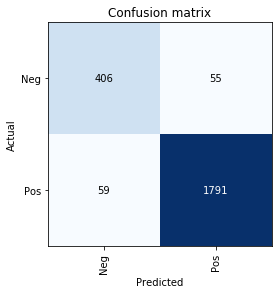

In [98]:
interpretations.plot_confusion_matrix()

In [0]:
TN = 406
FN = 59
FP = 55
TP = 1791

In [102]:
# Accuracy

accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
accuracy

95.06707053223712

In [103]:
#recall

recall = (TP/(TP+FN))*100
recall

96.8108108108108

In [104]:
#precision

precision = (TP/(TP+FP))*100
precision

97.02058504875406

In [107]:
# Fmeasure

fmeasure = ((2*recall*precision)/(recall+precision))
fmeasure

96.9155844155844

In [108]:
# sensitivity

sensitivity = ( TP / (TP+FN) ) * 100
sensitivity

96.8108108108108

In [109]:
#Specificity 

specificity = ( TN/(TN+FP) ) * 100
specificity

88.06941431670282

In [110]:
#efficiency

efficiency = ( sensitivity + specificity + accuracy ) / 3
efficiency

93.31576521991691

In [0]:
y_test = list(target.numpy())
y_pred = preds.numpy()[:,1]

In [0]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_score = auc(fpr, tpr)

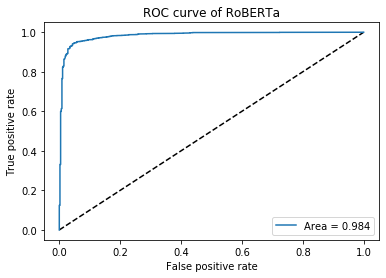

<Figure size 432x288 with 0 Axes>

In [115]:
plt.plot([0,1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'Area = {:.3f}'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of RoBERTa')
plt.legend(loc='best')
plt.show()
plt.savefig('binary.png')

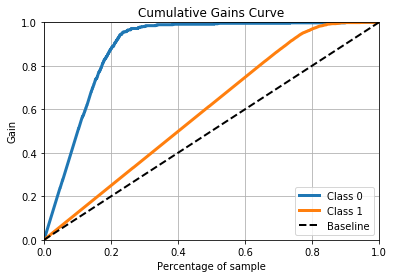

In [116]:
import scikitplot as skplt
y_preds_arr = preds.numpy()
skplt.metrics.plot_cumulative_gain(y_test, y_preds_arr)

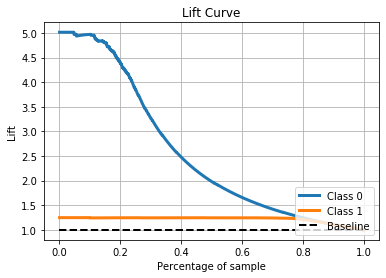

In [117]:
skplt.metrics.plot_lift_curve(y_test, y_preds_arr)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


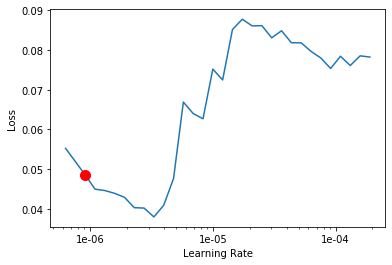

In [120]:
# find an appropriate lr
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
# unfreeze layers
learn.unfreeze()

In [0]:
# train using half precision
learn = learn.to_fp16()

In [125]:
text = "this product is  very bad!!!"
learn.predict(text)

(Category Neg, tensor(0), tensor([0.9974, 0.0026]))

In [126]:

text = "this product is amazing....!!!"
learn.predict(text)

(Category Pos, tensor(1), tensor([9.9273e-04, 9.9901e-01]))

In [0]:
# With scale

In [0]:
def biggernum(arr):
    if arr[0] > arr[1]:
        return arr[0]
    else: 
        return arr[1]

In [0]:
def prediction(str): 
    pred = learn.predict(str)
    print('The review class is: ', pred[0], ',',  'with a scale of ','{:.2f} '.format(biggernum(pred[2].numpy()) * 100), 'out of 100.') 

In [0]:
import plotly.express as px

In [131]:
msg1 = "I am not sure what quality it is. But definitely nobody will like it!!!!!!"
prediction(msg1)
pred = learn.predict(msg1)
vals = [round(biggernum(pred[2].numpy()*100), 2), round(100- biggernum(pred[2].numpy()*100),2)] 
fig = px.pie(pred, values=vals, title=msg1)
fig.show()


The review class is:  Neg , with a scale of  99.34  out of 100.


In [132]:
msg2 = "this phone case is cute, but it's not that sturdy..."
prediction(msg2)
pred = learn.predict(msg2)
vals = [round(biggernum(pred[2].numpy()*100), 2), round(100- biggernum(pred[2].numpy()*100),2)] 
fig = px.pie(pred, values=vals, title=msg2)
fig.show()

The review class is:  Neg , with a scale of  52.77  out of 100.


In [0]:
# Getting Predictions for test data

In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [135]:
test_df.head(3)

,reviews,label
0,broke almost fit phone well minute bolster got...,Neg
1,exactly needed shorter cable standard size com...,Pos
2,best screen protector use nothing else,Pos


In [136]:
_, test_pred_values = get_preds_as_nparray(DatasetType.Test)

In [137]:
test_pred_values

array([0, 1, 1, 1, ..., 1, 1, 1, 1])

In [0]:
test_df["predicted_class"] = test_pred_values

In [139]:
test_df.head(10)

,reviews,label,predicted_class
0,broke almost fit phone well minute bolster got...,Neg,0
1,exactly needed shorter cable standard size com...,Pos,1
2,best screen protector use nothing else,Pos,1
3,great service great product thanks,Pos,1
4,seems like great solid keyboard key type smoot...,Pos,1
5,tireless charge work phone get lined right cha...,Neg,1
6,shiny instead matter inside lip case little sh...,Pos,1
7,good deal make sure coat clear nail polish bei...,Pos,1
8,hard time consuming managed replaced glass gal...,Pos,1
9,delicate,Pos,1


In [140]:
test_df.tail(10)

,reviews,label,predicted_class
2279,unable dropped foot high shelf unto tile floor...,Pos,1
2280,finally long enough cord charge phone sit righ...,Pos,1
2281,button action suuuucks mash button transfer mo...,Neg,0
2282,needed short cable would work car perfect dont...,Pos,1
2283,mounted dash crown victoria amazed able stick ...,Pos,1
2284,stick window dash board even clean window twic...,Neg,1
2285,received product stated good condition used pr...,Pos,1
2286,really handy stretch much though,Pos,1
2287,it great case good male able rubber plastic sm...,Pos,1
2288,purchased phone fit tried holding phone pocket...,Pos,1


In [0]:
# Saving/Loading the model weights

In [0]:
def save_model(learner, file_name):
    st = learner.model.state_dict()
    torch.save(st, file_name) # will save model in current dir # backend is pickle 

def load_model(learner, file_name):
    st = torch.load(file_name)
    learner.model.load_state_dict(st)

# monkey patching Learner methods to save and load model file
Learner.save_model = save_model
Learner.load_model = load_model

In [143]:
save_model

<function __main__.save_model>

In [0]:
path1 = 'drive/My Drive/Roberta_models/Binary/12&45'

In [0]:
learn.save_model('mymodel.path1')

In [0]:
learn.load_model('mymodel.path1')

In [0]:
test_df = test_df[["reviews", "label", "predicted_class"]]

In [148]:
test_df.head(10)

,reviews,label,predicted_class
0,broke almost fit phone well minute bolster got...,Neg,0
1,exactly needed shorter cable standard size com...,Pos,1
2,best screen protector use nothing else,Pos,1
3,great service great product thanks,Pos,1
4,seems like great solid keyboard key type smoot...,Pos,1
5,tireless charge work phone get lined right cha...,Neg,1
6,shiny instead matter inside lip case little sh...,Pos,1
7,good deal make sure coat clear nail polish bei...,Pos,1
8,hard time consuming managed replaced glass gal...,Pos,1
9,delicate,Pos,1


In [0]:
test_df = test_df.replace({'predicted_class': {0: 'Neg', 1: 'Pos'}})

In [150]:
test_df.head(10)

,reviews,label,predicted_class
0,broke almost fit phone well minute bolster got...,Neg,Neg
1,exactly needed shorter cable standard size com...,Pos,Pos
2,best screen protector use nothing else,Pos,Pos
3,great service great product thanks,Pos,Pos
4,seems like great solid keyboard key type smoot...,Pos,Pos
5,tireless charge work phone get lined right cha...,Neg,Pos
6,shiny instead matter inside lip case little sh...,Pos,Pos
7,good deal make sure coat clear nail polish bei...,Pos,Pos
8,hard time consuming managed replaced glass gal...,Pos,Pos
9,delicate,Pos,Pos


In [0]:
test_df.to_csv('results.csv')